# shower-event.py
https://github.com/grand-mother/grand/blob/master/examples/simulation/shower_event.py

In this example we compute the voltage at antenna output for a given simulated shower. This consist basically in a scalar product between the Efield vector and the antenna effective length, the complex vectorial information encoding the antenna response:
$$ V = \vec{E} \cdot \vec{l_{eff}}$$

More details on the effective length & voltage computation can be found in particular here: https://github.com/grand-mother/grand/blob/master/docs/GRANDscripts.pdf





First we import relevant packages.




In [1]:
from grand import LTP, CartesianRepresentation
from grand import grand_add_path_data
from grand.io.root_files import File
from grand.basis.type_trace import ElectricField
from grand.simu.du.antenna_model import AntennaModel
from grand.simu.du.process_ant import AntennaProcessing
from grand.simu.shower.gen_shower import ShowerEvent

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

params = {
    "legend.fontsize": 14,
    "axes.labelsize": 22,
    "axes.titlesize": 23,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "figure.figsize": (10, 8),
    "axes.grid": False,
}
plt.rcParams.update(params)

Welcome to JupyROOT 6.26/02


Now we load the Shower object from an example ROOT file with an electric-field information.

In [2]:
# Load the radio shower simulation data
shower = ShowerEvent()
e_path = grand_add_path_data("test_efield.root")
tefield= File(e_path)
shower.origin_geoid  = tefield.run.origin_geoid  # [lat, lon, height]
shower.load_root(tefield.shower)                 # calculates grand_ref_frame, shower_frame, Xmax in LTP etc

#shower = ShowerEvent.load("../../tests/simulation/data/zhaires")

print("---------------------------------")
print("Shower Frame:")
print(f"{vars(shower.frame)}")
print(f"origin_geoid: {shower.origin_geoid} # lat, lon, alt")
print(f"Core={shower.core.flatten()}")
print(f"obstime: {shower.frame.obstime}")
print(f"Zenith: {shower.zenith}")
print(f"Azimuth: {shower.azimuth}")
print(f"Xmax (shc): {shower.maximum}")
print("---------------------------------")


---------------------------------
Shower Frame:
{'location': ECEF([[-546142.87234436],
      [4771222.9364452 ],
      [4186334.74943439]]), 'basis': array([[ 0.08399931, -0.65427316,  0.75157883],
       [ 0.99279305,  0.11964829, -0.0068007 ],
       [-0.08547561,  0.7467335 ,  0.65960822]]), 'orientation': 'NWU', 'magnetic': True, 'declination': -0.5184295978295808, 'magmodel': 'IGRF13', 'obstime': '2020-01-01', 'rotation': None}
origin_geoid: [41.27 96.53  0.  ] # lat, lon, alt
Core=[   0.    0. 2025.]
obstime: 2020-01-01
Zenith: 92.0999984741211
Azimuth: 110.0
Xmax (shc): [[  98786.24]
 [-271412.97]
 [  12588.98]]
---------------------------------


The shower is associated with a Local Tangent Plane (LTP) frame centered on the shower core. Hence the Xmax position is given with respect to the shower frame in LTP .

Now we load the Antenna model, which contains the effective length information of three antenna arms, under the form of 2 matrixes (real+imaginary for the 2 componants $l_{eff}^{\theta}$ and $l_{eff}^{\phi}$) with 3 dimensions (frequency, zenith, azimuth). 

This is done here: https://github.com/grand-mother/grand/blob/master/grand/simu/du/antenna_model.py


In [3]:
# Define an antenna model
#
# A tabulated model of the GP300 antenna is used. Note that all three arms of an
# can be accessed as antenna_model.leff_ew (leff_sn, leff_z)
antenna_model  = AntennaModel()


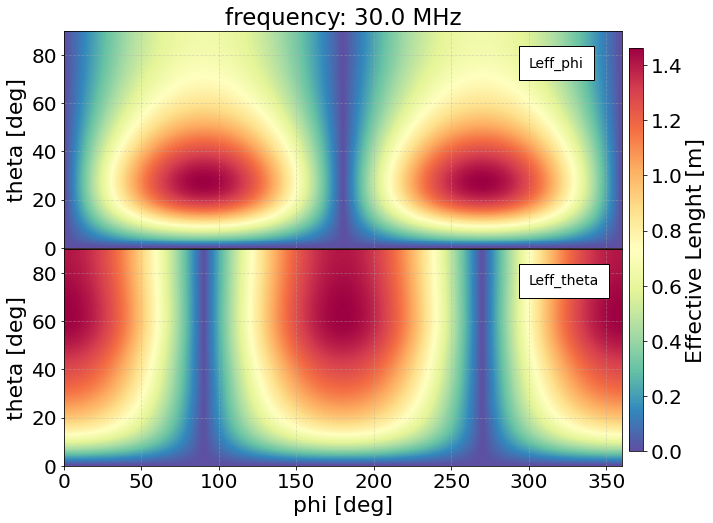

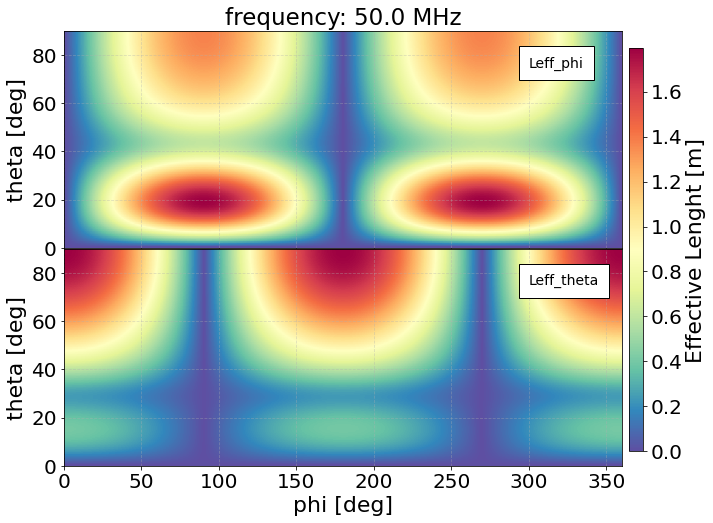

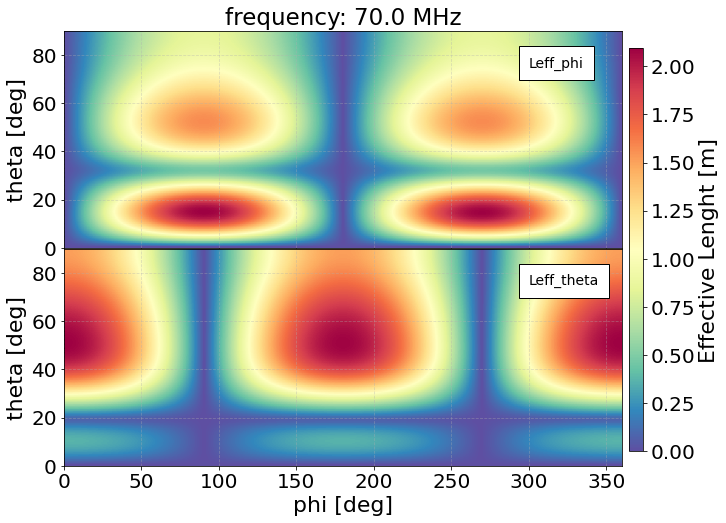

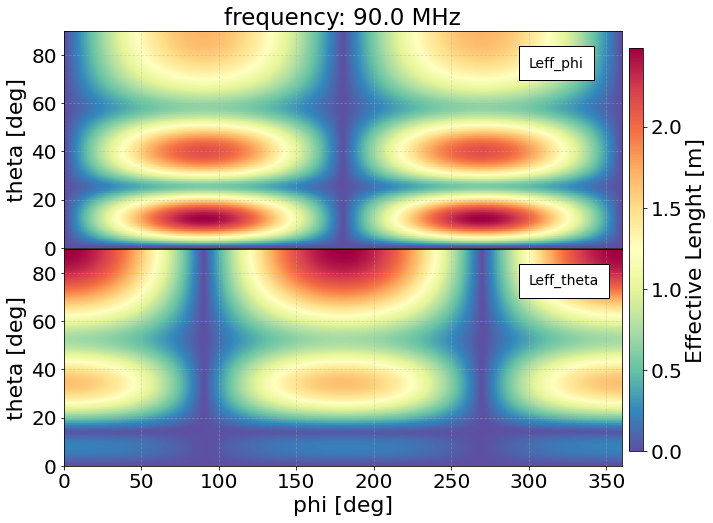

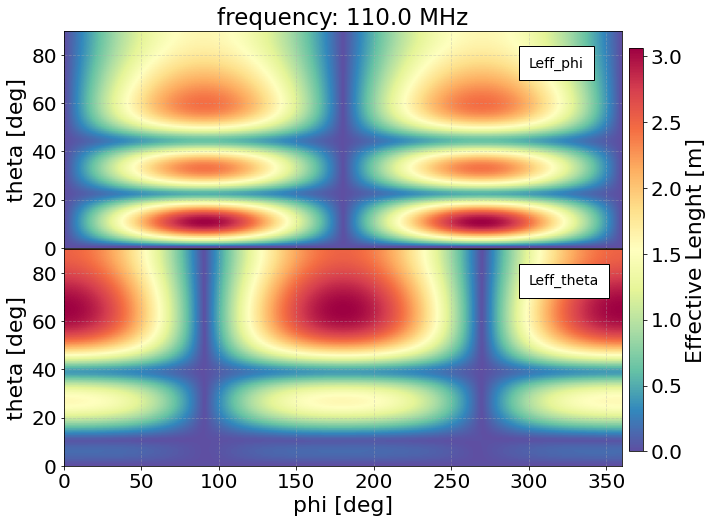

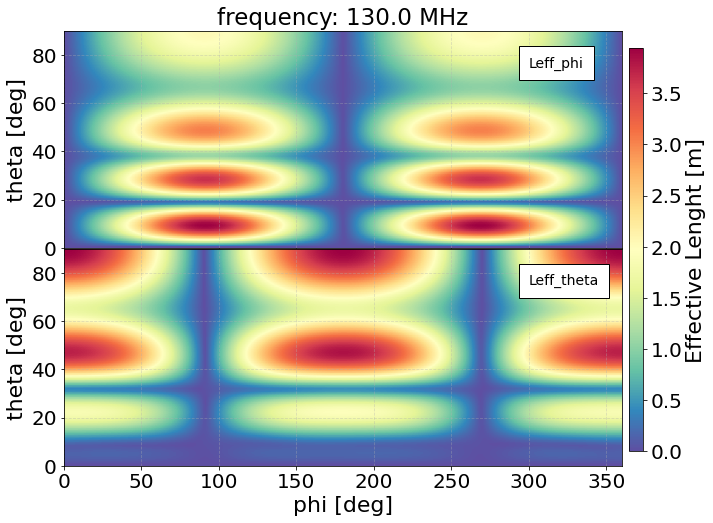

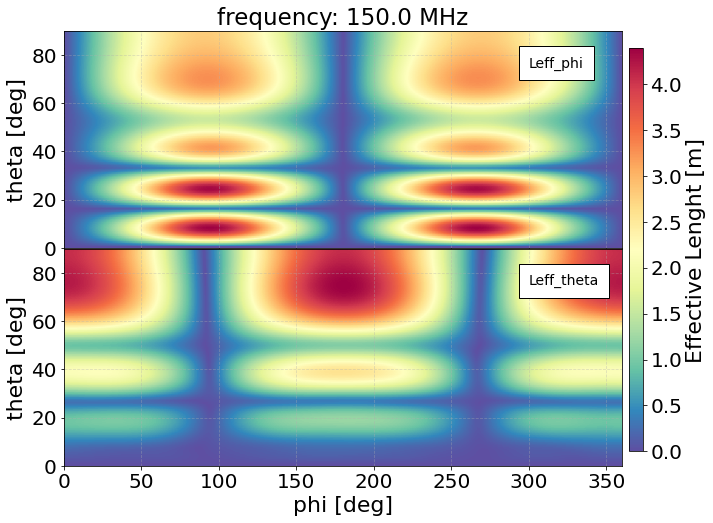

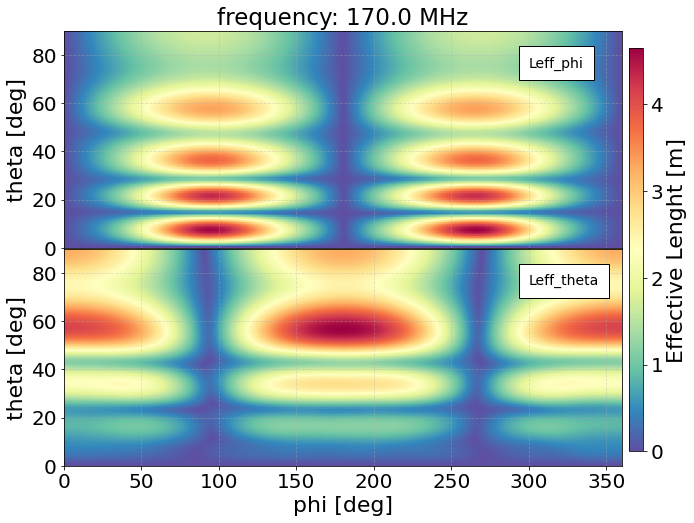

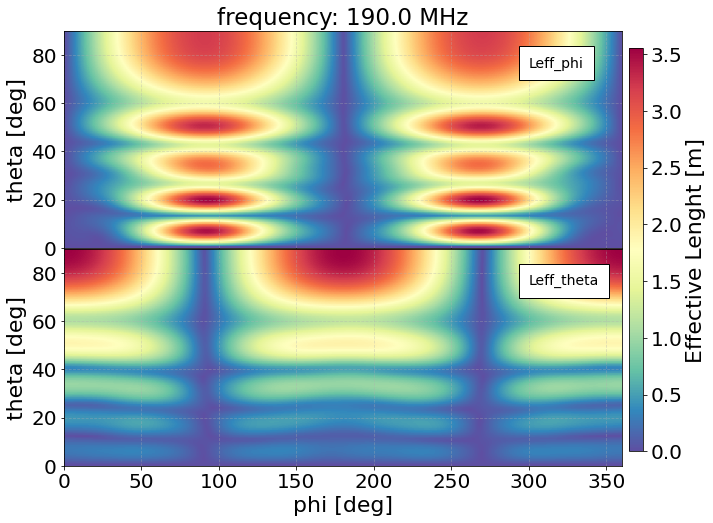

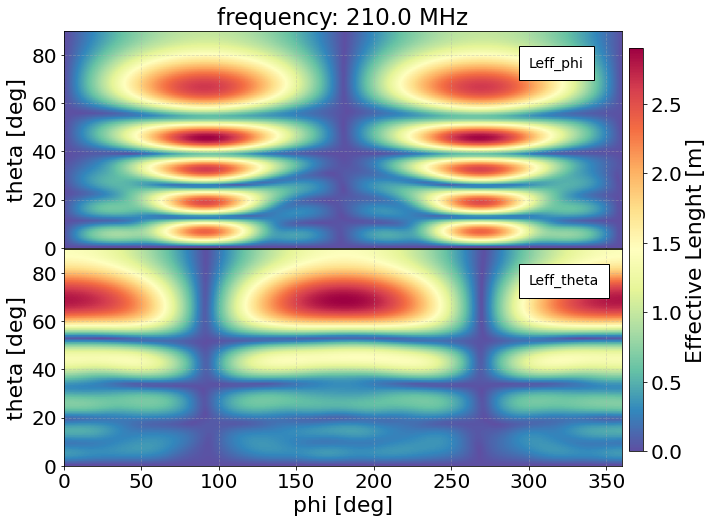

In [4]:
# Plot tabulated phi and zenith angle (wrt antenna frame) dependence of
# effective lengths of antenna in phi and zenith direction (e_phi, e_theta).
phi = antenna_model.leff_ew.phi
theta = antenna_model.leff_ew.theta
frequency = antenna_model.leff_ew.frequency
X, Y = np.meshgrid(phi, theta)

n = 10  # number of plots to print
z = (frequency.max() / 1e6) / n
z = int(z - (z % 10))  # pick multiple of 10
# plt.rcParams['axes.grid'] = False
for i in range(n):
    fig = plt.figure()
    gs = GridSpec(80, 100)
    ax1 = plt.subplot(gs[:40, :])
    ax2 = plt.subplot(gs[40:, :])
    f1 = ax1.imshow(
        np.abs(antenna_model.leff_sn.leff_phi_reim[z * i, :, :]).T,
        cmap="Spectral_r",
        label="Leff_phi",
        extent=[phi.min(), phi.max(), theta.min(), theta.max()],
    )
    f2 = ax2.imshow(
        np.abs(antenna_model.leff_sn.leff_theta_reim[z * i, :, :]).T,
        cmap="Spectral_r",
        label="Leff_theta",
        extent=[phi.min(), phi.max(), theta.min(), theta.max()],
    )
    ax1.set_title("frequency: %.1f MHz" % (frequency[z * i] / 1e6))
    ax1.set_ylabel("theta [deg]")
    ax2.set_ylabel("theta [deg]")
    ax2.set_xlabel("phi [deg]")
    ax1.set_aspect("auto")
    ax2.set_aspect("auto")
    ax1.set_xticklabels([])
    ax1.grid(ls="--", alpha=0.4)
    ax2.grid(ls="--", alpha=0.4)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    fig.colorbar(f1, cax=cbar_ax, label="Effective Lenght [m]")
    # For legend
    ax1.text(300, 75, "Leff_phi", bbox={"facecolor": "white", "pad": 10}, fontsize=14)
    ax2.text(300, 75, "Leff_theta", bbox={"facecolor": "white", "pad": 10}, fontsize=14)
    # plt.savefig('/Users/rameshkoirala/Documents/GRAND/grandlib/Plots/effective_length_freq%sMHz.png'%str(int(frequency[20*i]/1e6)), bbox_inches='tight')

We then loop on all antennas.

antenna.compute_voltage is called with parameters:
- $X_{max}$ (in shower frame)
- Electric field info at this antenna (in shower frame)
- shower frame (LTP centered at antenna)

In compute voltage, we do the following: 
direction = vector $\vec{X_{max}X_{ant}}$
- Convert the Efield timetraces ($E_x(t),E_y(t),E_z(t)$) expressed in the Efield frame, an LTP centered @ core) in the frequency domain through FFT
- compute the direction of $X_{max}$ from $X_{ant}$.
- Compute the Leff values for the direction "direction" where the radiation comes from. These are interpolatted from tabulated values in https://github.com/grand-mother/grand/blob/master/grand/simu/du/process_ant.py#L137
- Write the Leff vector in the E_field frame.
- Perform the scalar product $\vec{E} \cdot \vec{L_{eff}}$ in the frequency domain and come back to the time domain through inverse Fourier transform.

Result is $V(t)$ for this (EW) antenna arm.


antenna_index=0
0 Antenna pos in shower frame [ 2120.02880859 -2040.00097656  2028.79003906]
{'location': ECEF([[-546142.87234436],
      [4771222.9364452 ],
      [4186334.74943439]]), 'basis': array([[ 0.08399931, -0.65427316,  0.75157883],
       [ 0.99279305,  0.11964829, -0.0068007 ],
       [-0.08547561,  0.7467335 ,  0.65960822]]), 'orientation': 'NWU', 'magnetic': True, 'declination': -0.5184295978295808, 'magmodel': 'IGRF13', 'obstime': '2020-01-01', 'rotation': None} [ 2120.02880859 -2040.00097656  2028.79003906] antenna pos LTP in shower frame
---------------------------------
antenna frame:
{'location': ECEF([[-548163.50224619],
      [4771106.74133893],
      [4189280.19823777]]), 'basis': array([[ 0.08445534, -0.65447007,  0.75135626],
       [ 0.99272944,  0.12016845, -0.00691369],
       [-0.08576451,  0.74647737,  0.65986057]]), 'orientation': 'NWU', 'magnetic': True, 'declination': -0.52719882295861, 'magmodel': 'IGRF13', 'obstime': '2020-01-01', 'rotation': None}
---

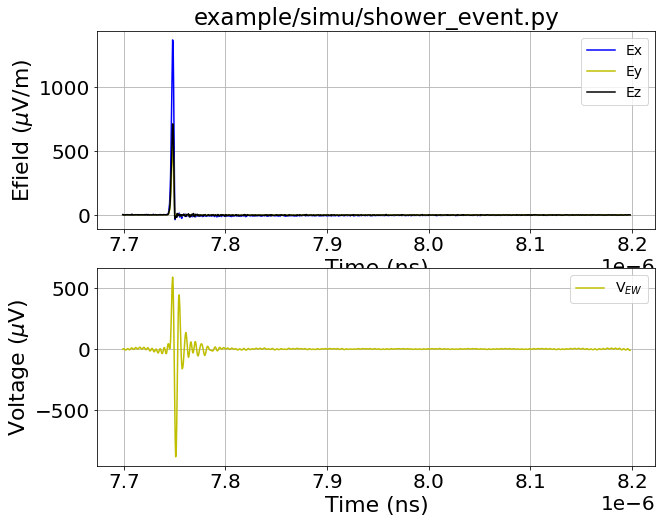

---------------------------------------------------------------



In [ ]:
for antenna_index in range(tefield.du_count): # for all hit antennas.
    print(f"antenna_index={antenna_index}")

    # Compute the antenna local frame
    #
    # The antenna is placed within the shower frame. It is oriented along the
    # local magnetic North by using an ENU/LTP frame (x: East, y: North, z: Upward)
    # RK: if antenna location is saved in LTP frame, next step is not required.
    antenna_location = LTP(
        x=tefield.du_xyz[antenna_index, 0],
        y=tefield.du_xyz[antenna_index, 1],
        z=tefield.du_xyz[antenna_index, 2],
        frame=shower.frame,
    )
    antenna_frame = LTP(
        location=antenna_location,
        orientation="NWU",
        magnetic=True,
        obstime=shower.frame.obstime,
    )
    antenna = AntennaProcessing(model_leff=antenna_model.leff_sn, pos=antenna_frame)

    print(f"{antenna_index} Antenna pos in shower frame {tefield.du_xyz[antenna_index]}")
    print(
        f"{vars(antenna_location)} {antenna_location.flatten()} antenna pos LTP in shower frame"
    )
    print("---------------------------------")
    print("antenna frame:")
    print(vars(antenna_frame))
    print("---------------------------------")

    # Compute the voltage on the antenna
    #
    # The electric field is assumed to be a plane-wave originating from the
    # shower axis at the depth of maximum development. Note that the direction
    # of observation and the electric field components are provided in the
    # shower frame. This is indicated by the `frame` named argument.
    e_trace = CartesianRepresentation(
        x=tefield.traces[antenna_index, 0],
        y=tefield.traces[antenna_index, 1],
        z=tefield.traces[antenna_index, 2],
    )
    efield_idx = ElectricField(tefield.traces_time[antenna_index] * 1e-9, e_trace)

    print("compute_voltage")
    # Xmax, Efield, and input frame are all in shower frame.
    voltage = antenna.compute_voltage(shower.maximum, efield_idx, shower.frame)
    print(f"\nVpp= {max(voltage.V) - min(voltage.V)}")

    plt.figure()
    plt.subplot(211)
    plt.title("example/simu/shower_event.py")
    plt.plot(efield_idx.a_time, efield_idx.e_xyz.x, label="Ex", color='b')
    plt.plot(efield_idx.a_time, efield_idx.e_xyz.y, label="Ey", color='y')
    plt.plot(efield_idx.a_time, efield_idx.e_xyz.z, label="Ez", color='k')
    plt.xlabel("Time (ns)")
    plt.ylabel(r"Efield ($\mu$V/m)")
    plt.grid()
    plt.legend(loc="best")
    plt.subplot(212)
    plt.plot(voltage.t, voltage.V, label="V$_{EW}$", color='y')
    plt.xlabel("Time (ns)")
    plt.ylabel(r"Voltage ($\mu$V)")
    plt.legend(loc="best")
    plt.grid()
    #plt.savefig(f'test_efield_voltage_ant{antenna_index}.png')
    plt.show()
    print("---------------------------------------------------------------\n")
    input("Type return for next antenna\n")
